## Table of Contents
- [Introduction](#Introduction)
    - [Imports](#Imports)
    - [Loading local data](#Loading-local-data-for-this-Project)
- [At what times of year do movies tend to be released?](#At-what-times-of-year-do-movies-tend-to-be-released?)
    - [How many movies are released per month?](#How-many-movies-are-released-per-month?)
    - [What are the yearly trends of movie releases?](#What-are-the-yearly-trends-of-movie-releases?)
- [Genre-specific analysis](#Genre-specific-analysis)
    - [What are the most popular movie genres?](#What-are-the-most-popular-movie-genres?)
    - [What is the pattern of movie genre releases during a given year?](#What-is-the-pattern-of-movie-genre-releases-during-a-given-year?)
    - [Visualizing genre releases during a given year - Part 1](#Visualizing-genre-releases-during-a-given-year---Part-1)
    - [Visualizing genre releases during a given year - Part 2](#Visualizing-genre-releases-during-a-given-year---Part-2)
- [Finances](#Finances)        
    - [Comparing budgets between genres](#Comparing-budgets-between-genres)
    - [The relationship of domestic gross to a movie's budget](#The-relationship-of-domestic-gross-to-a-movie's-budget)
    - [Profitability in each genre](#Profitability-in-each-genre)
    - [How much of an impact do reviews have on profitability?](#How-much-of-an-impact-do-reviews-have-on-profitability?)
        - [Critic Reviews - Rotten Tomatoes](#Critic-Reviews---Rotten-Tomatoes)
        - [Critic Reviews - Metacritic](#Critic-Reviews---Metacritic)
        - [Audience Reviews - IMDB](#Audience-Reviews---IMDB)
    - [Return on Investment: a story of outliers](#Return-on-Investment:-a-story-of-outliers)
- [Concluding Thoughts](#Concluding-thoughts)

# Introduction
In this project, I look at box office data taken from the past twenty years, with the goal of being able to predict a 
movie's return on investment, based on various characteristics of the movie. Some of these characteristics are 
factors that go into pre-production, such as budget and month of release, while others are known only after a 
movie's release, such as critical reception. 


Here, we explore the data to assess general trends in movie releases in relation to profitability. 

## Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

## Loading local data

In [16]:
data = pd.read_csv('/Users/benisonp/Documents/Data Science/Springboard/Capstone 1/domestic_boxoffice.csv', 
                   index_col=[0])

# At what times of year do movies tend to be released?

## How many movies are released per month?

Text(0.5, 1.0, 'Number of Movies Released Per Month')

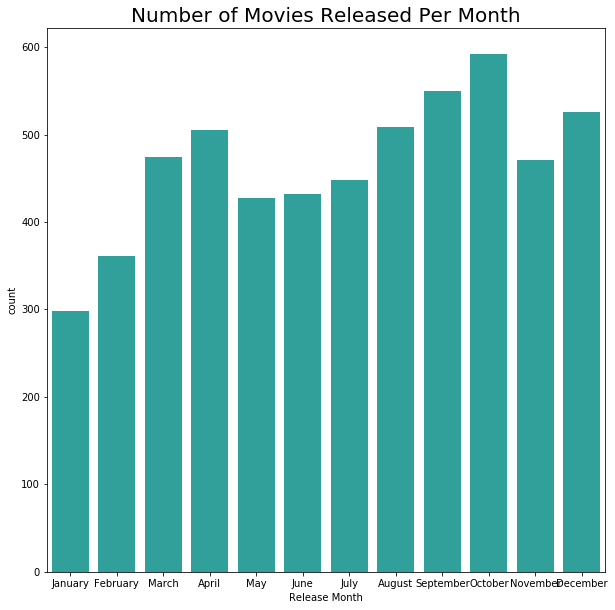

In [17]:
#Order Release Month correctly
data['Release Month'] = pd.Categorical(data['Release Month'], 
                                       ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                        'August', 'September', 'October', 'November', 'December'])
# Set a large figure size
mpl.rcParams['figure.figsize'] = (10,10)

p = sns.countplot(data=data, x = 'Release Month', color='lightseagreen') #Barplot
p.set_title('Number of Movies Released Per Month', fontsize=20)

There are two peaks: March and April releases,as well as August through October. 
This raises the question: **Is this a general pattern we observe across multiple years?**

## What are the yearly trends of movie releases?

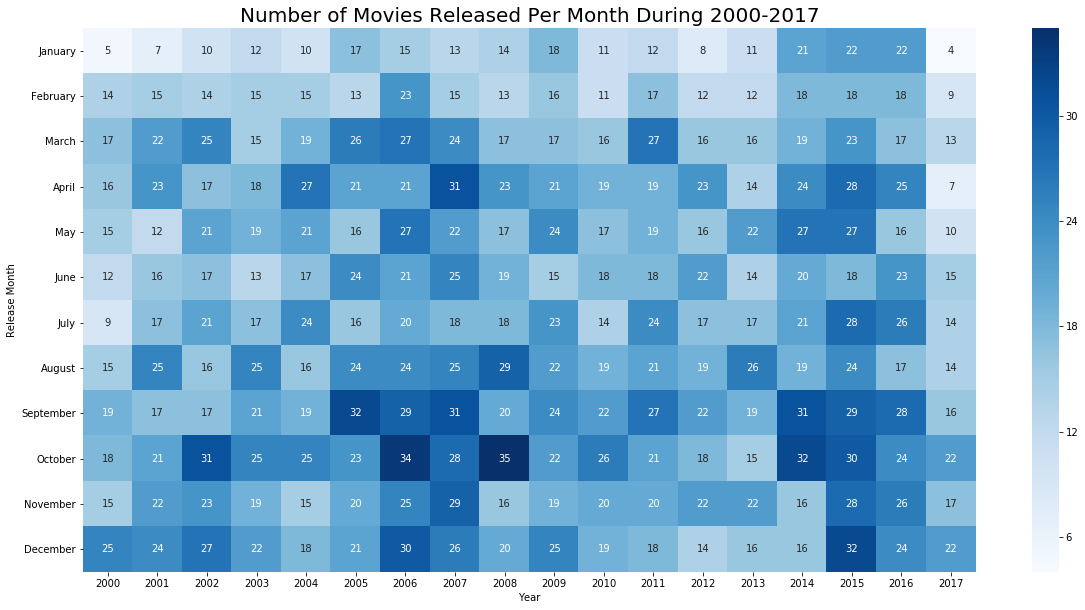

In [18]:
df_2000_2017 = data[(data.Year>=2000) & (data.Year <=2017)]
df_2000_2017 = df_2000_2017.groupby(['Year', 'Release Month']).size().reset_index()
df_2000_2017.columns = ['Year', 'Release Month', 'Count']
df_2000_2017 = df_2000_2017.pivot(index='Release Month', columns='Year', values='Count') 

mpl.rcParams['figure.figsize'] = (20,10)
plot = sns.heatmap(df_2000_2017, cmap='Blues', annot=True, fmt='g') 
plot.set_title('Number of Movies Released Per Month During 2000-2017', fontsize=20)
plot

Although there is some year to year fluctuation, there is a broad pattern of more movies being released in March 
and April, as well as towards the end of the year, as shown by the dark colors in those times of year.


The next question we can ask is: **what is the breakdown of movies that are being released, by genre?**

## Genre-specific analysis

## What are the most popular movie genres?

Text(0.5, 1.0, 'Most Common Movie Genres')

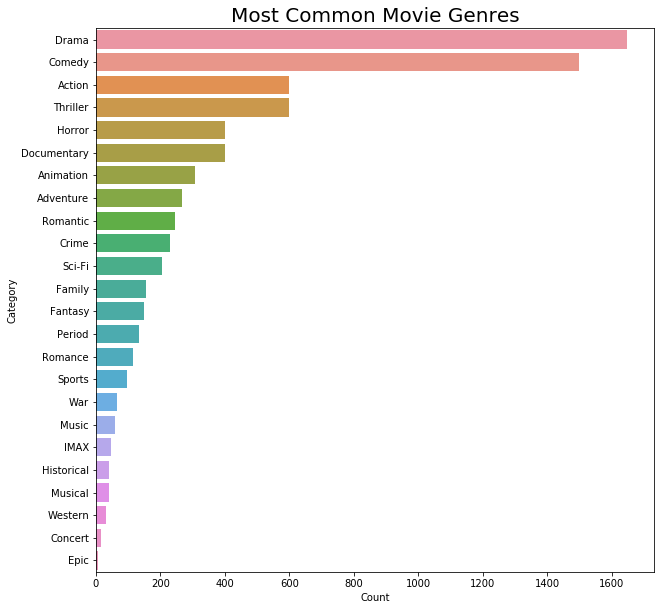

In [19]:
# Trimming datbase to only contain known genres
known_genres = data[data['Genre'].str.contains('Unknown') == False].reset_index(drop=True)
genre_count = known_genres.groupby(by='Genre').size()
genre_count = genre_count.reset_index(level=[0])
genre_count.columns = ['Genre', 'Count']

# Dataset to visualize counts of each movie genre
cleaned = known_genres.set_index('Title').Genre.str.split(' ', expand=True).stack()
genre_one_hot_df = pd.get_dummies(cleaned).groupby(level=0).sum() #One hot encoding the genres
long_df = pd.melt(genre_one_hot_df, var_name = 'Category', value_name = 'Count')
long_df_groupby = long_df.groupby(by='Category').sum()  

# Creating data to visualize raw counts by category
genre_count_data = long_df_groupby.reset_index()  
genre_count_data

# Barplot of number of movies per genre
mpl.rcParams['figure.figsize'] = (10,10)
plot = sns.barplot(data = genre_count_data.sort_values('Count', ascending=False), x ='Count', y = 'Category') 
plot.set_title('Most Common Movie Genres', fontsize=20)

Despite the predominance of action movies in the public consciousness, it is clear that the vast majority of movies
released are actually dramas and comedies! For the rest of this analysis, I will focus on the top 5 genres.

## Visualizing genre releases during a given year - Part 1

In [20]:
# List of top 5 genres by count
top_5_list = list(genre_count_data.sort_values(by='Count', ascending=False).reset_index(drop=True)['Category'][0:5])
top_5_genres = known_genres.copy()
top_5_genres_split = top_5_genres['Genre'].str.split(' ', expand=True)
top_5_genres['Genre 1'] = top_5_genres_split[0]
top_5_genres['Genre 2'] = top_5_genres_split[1] 

#Creating a database containing only movies from the top 5 genres; rows are repeated if multiple genres are present
top_5_df = top_5_genres[top_5_genres['Genre 1'].isin(top_5_list) | top_5_genres['Genre 2'].isin(top_5_list)]

top_5_genre1 = top_5_df.drop(['Genre', 'Genre 2'], axis=1) #Keep only Genre 2
top_5_genre1.columns = ['Genre' if col == 'Genre 1' else col for col in top_5_genre1.columns] #Rename 'Genre 1' to 'Genre'
top_5_genre2 = top_5_df.drop(['Genre', 'Genre 1'], axis=1) # Keep only Genre 1
top_5_genre2.columns = ['Genre' if col == 'Genre 2' else col for col in top_5_genre2.columns]
top_5_genres = pd.concat([top_5_genre1, top_5_genre2], sort=False).reset_index(drop=True) #Stack the dataframes
top_5_genres['Genre'].astype(str)
top_5_genres_df = top_5_genres[top_5_genres['Genre'].isin(top_5_list)] # Keep only top 5 genres

top_5_genres_unstacked = top_5_genres_df.groupby(['Release Month', 'Genre']).size().unstack() 
top_5_genres_unstacked = top_5_genres_unstacked.reset_index()


Text(0.5, 1.0, 'Movie Genres Per Month')

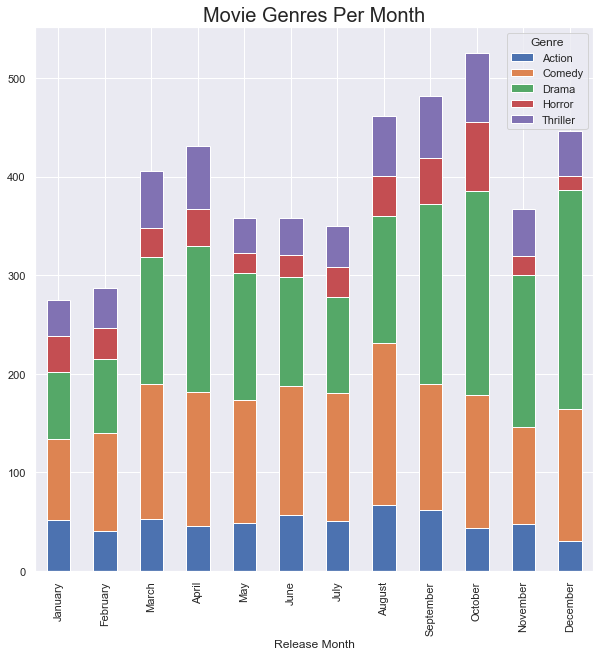

In [21]:
# Stacked barplot
top_5_barplot_df = top_5_genres_unstacked.set_index('Release Month')
sns.set()
plot = top_5_barplot_df.plot(kind='bar', stacked=True)
plot.set_title('Movie Genres Per Month', fontsize=20)

This visualization gives us another way of seeing the predominance of comedies and dramas; however, it might be 
interesting to be able to look at each genre and see if there are specific patterns associated with time of release
for each given genre. To do this, I generated a heatmap, which will be the next visualization.

## Visualizing genre releases during a given year - Part 2

Text(0.5, 1.0, 'Number of Movies Released Per Genre, Per Month')

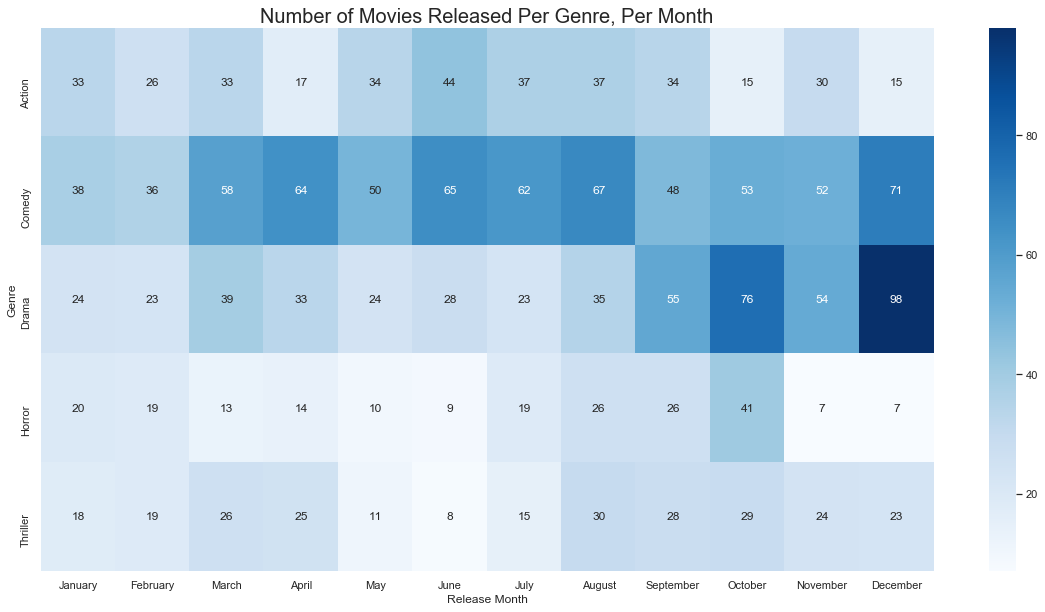

In [22]:
# Heatmap of genres per month
top_5_genres_cleaned = top_5_genres_df.dropna() 
top_5_grouped = top_5_genres_cleaned.groupby(['Release Month', 'Genre']).size().reset_index()
top_5_grouped.columns = ['Release Month', 'Genre', 'Count']
top_5_grouped = top_5_grouped.pivot(index='Genre', columns='Release Month', values='Count') 

mpl.rcParams['figure.figsize'] = (20,10)
plot = sns.heatmap(top_5_grouped, cmap='Blues', annot=True, fmt='g') 
plot.set_title('Number of Movies Released Per Genre, Per Month', fontsize=20)

This visualization reveals some interesting trends! We immediately see the following: 
    
- Dramas are primarily released towards the end of the year, starting around September. Why might this be the case? 
    Probably because the Oscars take place at the beginning of the upcoming year! This gives studios enough time to 
    showcase and campaign for their Oscar-worthy movies, and most studios clearly bet on their dramas more than any other
    genre.
- Comedies tend to be released consistently throughout the year, but show a December spike; this probably correlates
with Christmas, when studios tend to screen family-friendly movies to take advantage of the holiday season
- Action movies, when they are released, appear to cluster in the summer months, which is typically seen as 
blockbuster movie season! 
- Horror movies are released at very low frequency, but show a notable spike in October, which, of course, is when
Halloween takes place. Notably, there are very few action movies in this time, which makes sense as the demographic 
for action movies and horror movies tend to overlap significantly (young people). 

# Finances

For the purpose of this project, I focus on three main metrics when analyzing a movie's financial impact:
- Domestic Gross : This is the pure revenue generated at the domestic box office, without considering production budget.
- Profit: This is the difference between the revenue and budget.
- Domestic ROI Multiplier: This represents the proportionate return on investment relative to budget, expressed as a percentage of the budget.

In [23]:
top_5_genre_ROI_1 = top_5_df[['Domestic ROI Multiplier', 'Genre 1']]
top_5_genre_ROI_1.columns = ['Domestic ROI Multiplier', 'Genre']
top_5_genre_ROI_2 = top_5_df[['Domestic ROI Multiplier', 'Genre 2']]
top_5_genre_ROI_2.columns = ['Domestic ROI Multiplier', 'Genre']
top_5_genre_ROI = pd.concat([top_5_genre_ROI_1, top_5_genre_ROI_2]).reset_index(drop=True) 
top_5_genre_ROI['Genre'].astype(str)
top_5_genre_ROI_df = top_5_genre_ROI[top_5_genre_ROI['Genre'].isin(top_5_list)]

## Comparing budgets between genres

Text(0.5, 1.0, 'Movie budgets by Genre')

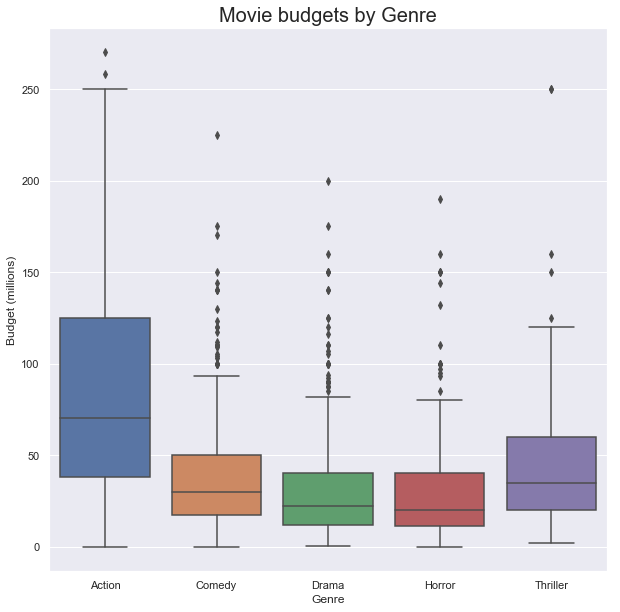

In [24]:
mpl.rcParams['figure.figsize'] = (10,10)
plot = sns.boxplot(x='Genre', y='Budget (millions)', data=top_5_genres_df) 
plot.set_title('Movie budgets by Genre', fontsize=20)

Budget represents a significant amount of risk on the part of the movie studio: the higher the budget, the greater
the risk and the higher the domestic gross required in order to turn a profit. In deciding what budget to assign to a 
movie, we can see clear diferences between genres.


Action movies have typically higher range of budgets. Does this necessarily translate into higher profits? We shall 
see!

Interestingly, although comedy, drama, and horror typically have lower budgets, we can see that there are a sizeable 
number of movies for which this rule does not hold. In some cases, it appears that studios bet heavily on these
genres to generate revenue, which is rather unusual. 

## The relationship of domestic gross to a movie's budget

Text(0.5, 1.0, 'Domestic gross in relation to budget')

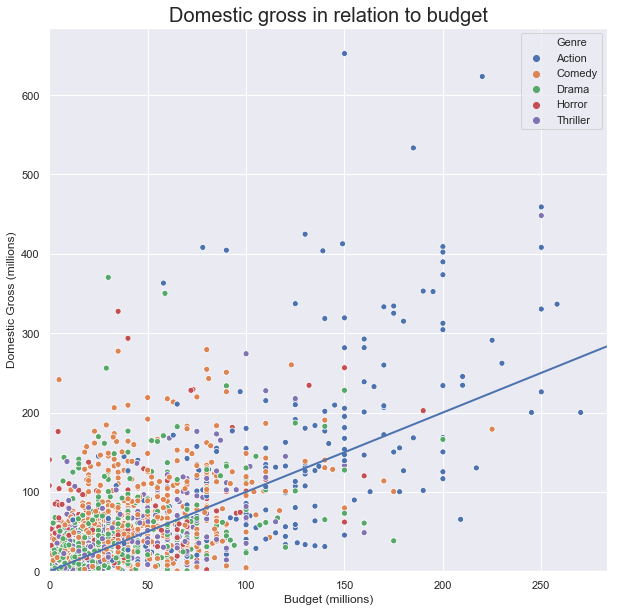

In [27]:
plot = sns.scatterplot(data=top_5_genres_df, x='Budget (millions)', y='Domestic Gross (millions)',
          hue='Genre')
plt.xlim(0, None)
plt.ylim(0, None)
plt.plot([0, 300], [0, 300], linewidth=2) # Setting a custom slope to establish break-even points
plot.set_title('Domestic gross in relation to budget', fontsize=20)

One might imagine that the bigger the budget, the more money a movie is likely to make, for reasons such as increased
production quality and being able to hire bigger movie stars/directors. As we can see, there is a loose positive
correlation, which I will explore in greater detail in the upcoming visualizations.

Here, the solid line represents the point at which a given budget is equal to the gross; in other words, the break-even point.
We can see that although many movies appear to be profitable, many movies are actually not profitable in the domestic market. That
leads us to the next question: are there genre-specific patterns of profitability?

## Profitability in each genre

Text(0.5, 2.2, 'Domestic profit in relation to budget, across top 5 genres')

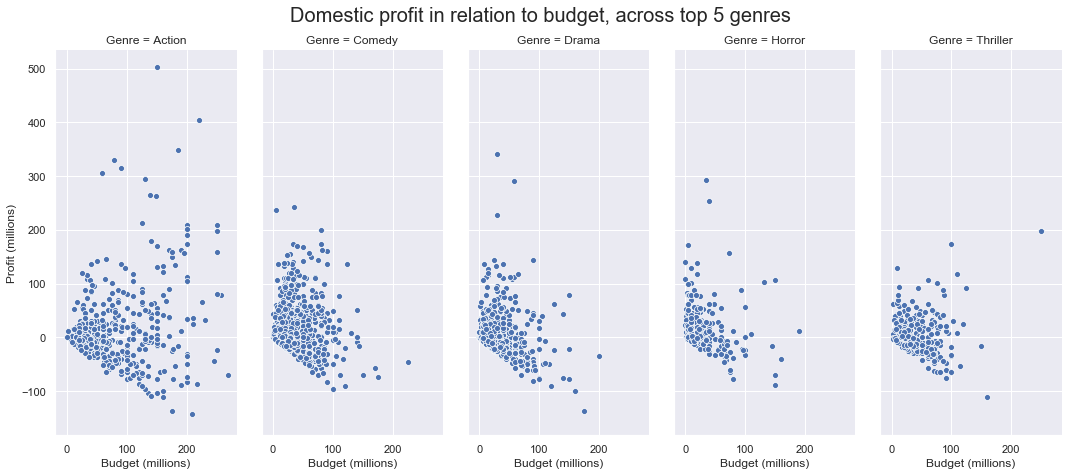

In [40]:
g = sns.FacetGrid(top_5_genres_df, col='Genre')
g.map(sns.scatterplot,'Budget (millions)', 'Profit (millions)')
plt.subplots_adjust(top=2)
g.fig.suptitle('Domestic profit in relation to budget, across top 5 genres', y=2.2, fontsize=20) # Place common title above axis titles

Once we partition the overall data into genres, the previous positive correlation becomes a lot weaker, if not 
disappearing outright! As we can see, in many cases, a higher budget does **not** lead to greater domestic profits; if anything,
the opposite seems to hold true for comedy, drama, and horror movies.  

Action movies are a classic case of high risk, high reward. Low budget action movies do not seem to generate much 
domestic profit relative to the size of investment, while the most profitable movies tend to be big-budget action movies. 
However, there is significant risk related to this, as we can see that many big budget (above $100 million) action
movies do not generate significant domestic profit, which is surprising.

## How much of an impact do reviews have on profitability?

### Critic Reviews - Rotten Tomatoes
Rotten Tomatoes is one of the best known movie review aggregators on the web, and generates an overall 'score' based
on critics evaluating a movie as being a binary 'fresh' or 'rotten'. The higher the score, the more reviewers that 
agree that it is a movie worth seeing, even if the movie is not necessarily a fantastic one.

Text(0.5, 1.4, 'Domestic profit in relation to RottenTomatoes ratings, across top 5 genres')

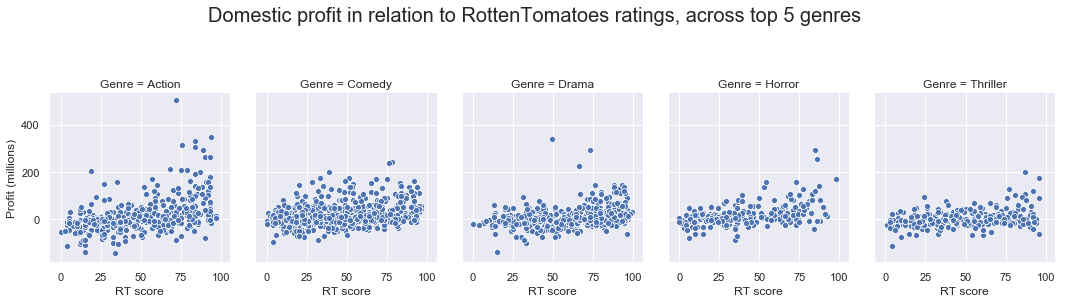

In [51]:
g = sns.FacetGrid(top_5_genres_df, col='Genre')
g.map(sns.scatterplot,'RT score', 'Profit (millions)')
plt.subplots_adjust(top=1)
g.fig.suptitle('Domestic profit in relation to RottenTomatoes ratings, across top 5 genres',
               y=1.4, fontsize=20) # Place common title above axis titles

Interestingly, despite its fame, it looks as if the Rotten Tomatoes score does not have much of a correlation with a 
movie's profitability, apart from action movies! This is something definitely worth exploring with a statistical 
approach, but in the meantime, let's look at Metascore, another metric of movie ratings.

### Critics Reviews - Metacritic
Another major website in the movie industry, Metacritic assigns scores out of 100 to each movie; unlike Rotten 
Tomatoes with its binary scoring system, the Metascore is meant to be interpreted in a grade-like fashion; the higher
the score, the better the movie is.

Text(0.5, 1.4, 'Domestic profit in relation to Metascore, across top 5 genres')

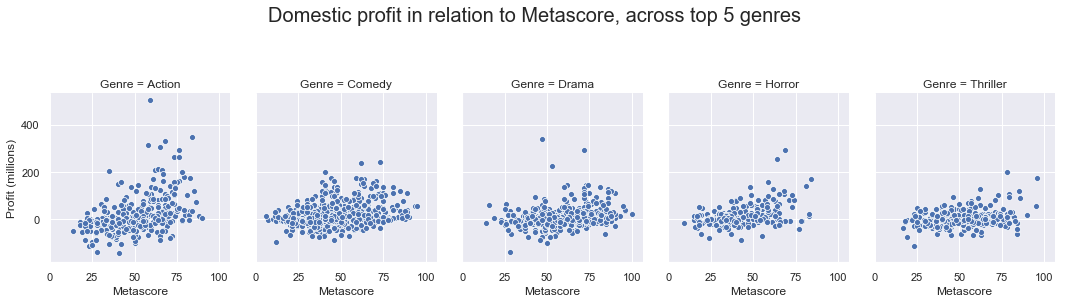

In [53]:
g = sns.FacetGrid(top_5_genres_df, col='Genre')
g.map(sns.scatterplot,'Metascore', 'Profit (millions)')
plt.subplots_adjust(top=1)
g.fig.suptitle('Domestic profit in relation to Metascore, across top 5 genres',
               y=1.4, fontsize=20) # Place common title above axis titles

Again, there does not seem to be much of a correlation in many of these cases, aside from action movies. This is 
particularly surprising for the drama genre, as I would have expected this genre to be the one most affected by critic
reviews, which has not yet seemed to be the case. 

### Audience Reviews - IMDB
Another notable movie scoring site is the International Movie Database, where users can score movies from 1-10. The
IMDB score is similar to the Metascore in interpretation, but assesses audience feedback rather than critical feedback. 

Text(0.5, 1.4, 'Domestic profit in relation to IMDB score, across top 5 genres')

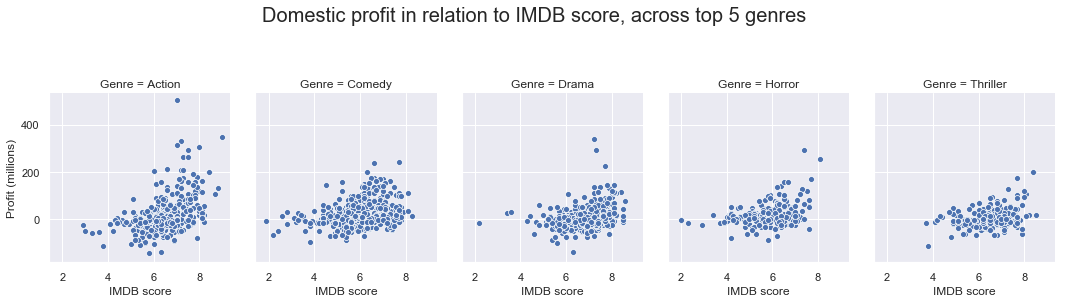

In [54]:
g = sns.FacetGrid(top_5_genres_df, col='Genre')
g.map(sns.scatterplot,'IMDB score', 'Profit (millions)')
plt.subplots_adjust(top=1)
g.fig.suptitle('Domestic profit in relation to IMDB score, across top 5 genres',
               y=1.4, fontsize=20) # Place common title above axis titles

Finally, we get a metric that appears to have some correlation with profit! On the face of it, this makes sense. A movie
makes money if audiences enjoy it, and IMDB scores are one way to gauge audience enjoyment. However, critic ratings
are often what audiences turn to for guidance in movie selection, and so it is strange that critic ratings apparently
do not correlate well to a movie's financial success. 

## Return on Investment: a story of outliers

Text(3, 61.221726000000004, 'Open Water')

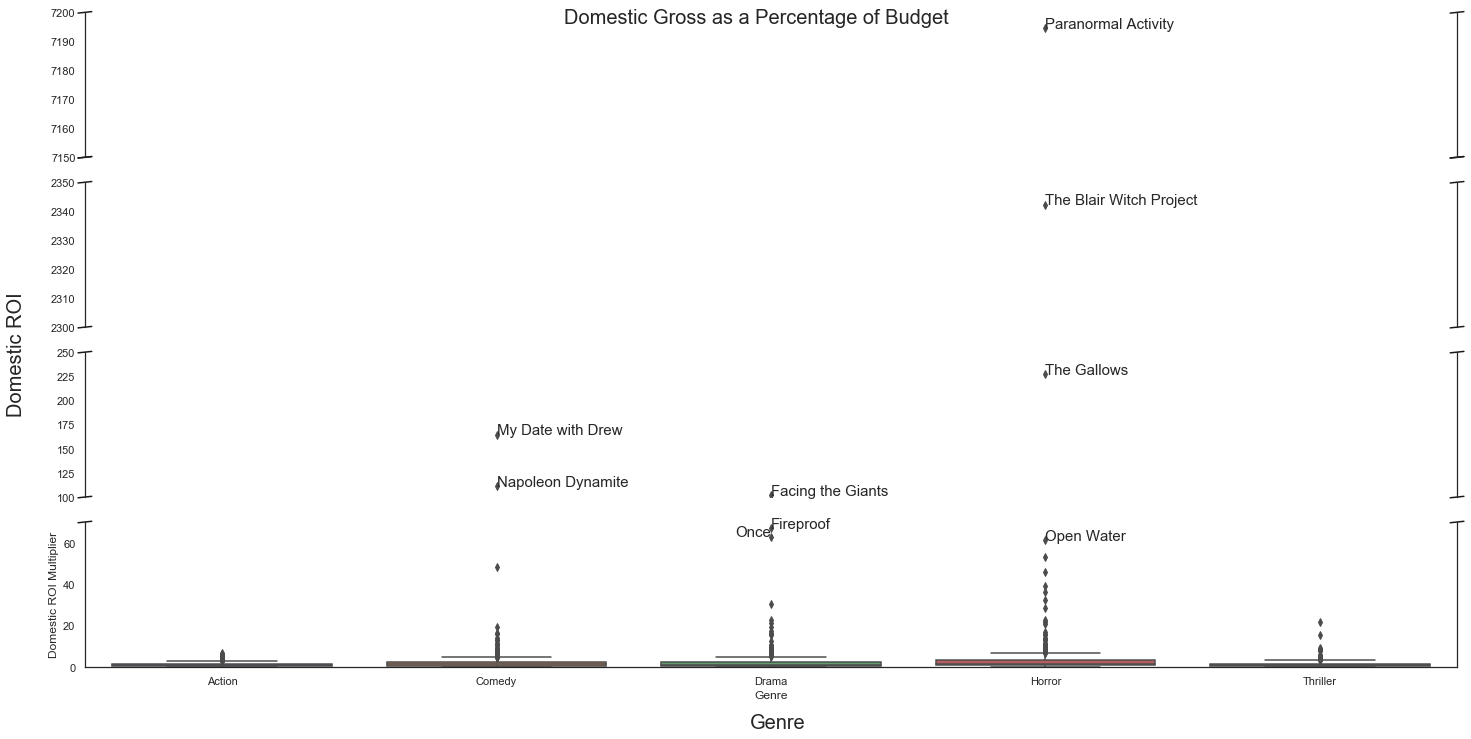

In [512]:
# Plotting a boxplot
sns.set_style('white')
f, axes = plt.subplots(4, 1, sharex=True)

sns.boxplot(x='Genre', y='Domestic ROI Multiplier', data=top_5_genres_df, ax=axes[3])
sns.boxplot(x='Genre', y='Domestic ROI Multiplier', data=top_5_genres_df, ax=axes[2])
sns.boxplot(x='Genre', y='Domestic ROI Multiplier', data=top_5_genres_df, ax=axes[1])
sns.boxplot(x='Genre', y='Domestic ROI Multiplier', data=top_5_genres_df, ax=axes[0])

axes[3].set_ylim(0,70)
axes[2].set_ylim(100,250)
axes[1].set_ylim(2300,2350)
axes[0].set_ylim(7150,7200)

for i in range(3):
    axes[i].set_xlabel('') 
    axes[i].set_ylabel('') 
    
for i in range(3):
    axes[i].spines['top'].set_visible(False) 
    axes[i].spines['bottom'].set_visible(False)  
axes[3].spines['top'].set_visible(False) 

# Placing the broken lines2
d = 0.005

kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs) # bottom-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs) # bottom-right diagonal

for i in range(3):
    kwargs = dict(transform=axes[i].transAxes, color='k', clip_on=False)
    axes[i].plot((-d, +d), (-d, +d), **kwargs) # bottom-left diagonal
    axes[i].plot((1 - d, 1 + d), (-d, +d), **kwargs) # bottom-right diagonal
    axes[i].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
    axes[i].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal  

kwargs.update(transform=axes[3].transAxes)  
axes[3].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # top-left diagonal
axes[3].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal  

plt.tight_layout()
f.suptitle("Domestic Gross as a Percentage of Budget", fontsize=20)
f.text(0.515, -0.02, 'Genre', ha='center', fontsize=20)
f.text(-0.02, 0.5, 'Domestic ROI', va='center', rotation='vertical', fontsize=20)

#Annotating some outliers
head = top_5_genres_df.sort_values(by=['Domestic ROI Multiplier'], ascending=[False]).head(10) #Top 10 outliers

axes[0].text(3, head['Domestic ROI Multiplier'].iloc[0], head['Title'].iloc[0], fontsize = 15)
axes[1].text(3, head['Domestic ROI Multiplier'].iloc[1], head['Title'].iloc[1], fontsize = 15) 
axes[2].text(3, head['Domestic ROI Multiplier'].iloc[2], head['Title'].iloc[2], fontsize = 15) 
axes[2].text(1, head['Domestic ROI Multiplier'].iloc[3], head['Title'].iloc[3], fontsize = 15) 
axes[2].text(1, head['Domestic ROI Multiplier'].iloc[4], head['Title'].iloc[4], fontsize = 15) 
axes[2].text(2, head['Domestic ROI Multiplier'].iloc[5], head['Title'].iloc[5], fontsize = 15) 
axes[3].text(2, head['Domestic ROI Multiplier'].iloc[6], head['Title'].iloc[6], fontsize = 15) 
axes[3].text(2, head['Domestic ROI Multiplier'].iloc[7], head['Title'].iloc[7], ha='right', fontsize = 15) 
axes[3].text(3, head['Domestic ROI Multiplier'].iloc[8], head['Title'].iloc[8], fontsize = 15) 

No, the diagram isn't broken, it's just significantly skewed, showing just how much of a fantastic outlier some movies are. 
Most movies do not actually generate a significant ROI multiplier, as seen by the flattened boxes
near the bottom, where most movies fall somewhere in between 0 and 5. Movies with large budgets tend to have low
multipliers, which explains why action movies do not have any notable outliers.

The more interesting story comes in looking at the genres in which outliers are practically common: as might be 
expected, the genres with lowest budgets tend to have the most outstanding outliers. Paranormal Activity was a movie
that had a legendary box office performance, in large part because the movie was shot with practically no budget. 

The sheer number of overperforming outliers in Horror suggests an alternative strategy in filmmaking, from a financial
perspective. Horror movies can represent a low-risk strategy with a better-than-average chance of breaking out as a 
box office success. Of course, the absolute profit is never as high as that of a big-budget action movie, and is
apparently somewhat seasonal, as evidenced in the first part of this analysis.  

# Concluding thoughts

Although blockbuster movies are often the first movies we think of when we think of financially successful movies, the truth is clearly more complicated. Action movies do generate immense amounts of profits when successful, but also
have significant losses when a movie flops. In addition, there seems to a relationship between critic ratings and the financial success of the movie, and pleasing the critics may be an issue the studio has to deal with.

Comparatively, movies in the comedy and horror genre appear to be critic-robust, primarily relying on the enjoyment
of the audience for their success. With their low budgets, they represent a low-risk, potentially high-reward 
investment, which is an alternative financial strategy that could be adopted by smaller studios. Blumhouse Films is a 
notable standout in this regard, and may well set the template for upstart studios moving forward.